In [2]:
print('Hello Google')
!pip install evaluate
!pip install accelerate -U
!pip install transformers[torch]
!pip install torchinfo
import torch

torch.__version__

Hello Google
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


'2.4.1+cu121'

In [3]:
import warnings

warnings.filterwarnings("ignore")

import os

import torch
import torch._dynamo

torch._dynamo.config.suppress_errors = True

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torchinfo import summary

import evaluate

metric_acc = evaluate.load("accuracy")  #
metric_f1 = evaluate.load("f1")
import numpy as np

tokenizer = None

# Tokenize helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)


def get_tokenizer(model_path):
    bert_tokenizer = AutoTokenizer.from_pretrained(model_path)

    return bert_tokenizer


def compute_metrics1(eval_pred, metric=metric_acc):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }



def train_classifier(model_path: str,
                     dataset,
                     output_dir="output",
                     train_batch_size=16,
                     eval_batch_size=8,
                     learning_rate= 5e-7, #1.25e-5
                     num_epochs=10,
                     metric_for_best_model="accuracy"
                     ):
    dataset = dataset.rename_column("label", "labels")  # to match Trainer
    print(dataset)
    tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["text"])
    print(tokenized_dataset["train"].features.keys())

    # Prepare model labels - useful for inference
    num_labels = 2
    id2label = {0: "PLASMA", 1: "NO_PLASMA"}
    label2id = {"PLASMA": 0, "NO_PLASMA": 1}

    # Fine-tune & evaluate
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.25
    )

    for param in model.parameters(): param.data = param.data.contiguous()

    print(" ############ Model Summary ######")
    print(model.cuda())

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        learning_rate=learning_rate,
        lr_scheduler_type='linear', #constant constant_with_warmup
        warmup_steps=0,
        num_train_epochs=num_epochs,
        torch_compile=True,  # optimizations
        optim="adamw_torch",  # improved optimizer
        logging_strategy="steps",
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        weight_decay=0.00, # prevent overfitting default 0.01
        #fp16=True,
        save_total_limit=2,
        load_best_model_at_end=True,
        #metric_for_best_model=metric_for_best_model,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    return model, trainer



In [4]:
from datasets import load_dataset

def prepare_trainingset(dataset_file_path:str, test_size=0.25):
    dataset = load_dataset("csv", data_files=dataset_file_path)
    dataset = dataset['train'].train_test_split(test_size=test_size, shuffle=True)

    return dataset

In [5]:
model_path = "allenai/scibert_scivocab_uncased" #"anferico/bert-for-patents"
tokenizer = get_tokenizer(model_path)


dataset = prepare_trainingset('plasma_training_dataset_0_1.csv')


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
model, trainer = train_classifier(model_path, dataset, num_epochs=10)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4818
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1607
    })
})


Map:   0%|          | 0/4818 [00:00<?, ? examples/s]

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 ############ Model Summary ######


The speedups for torchdynamo mostly come wih GPU Ampere or higher and which is not detected here.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.25, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

W1010 11:41:58.003000 139366365164160 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /usr/local/lib/python3.10/dist-packages/transformers/models/bert/modeling_bert.py line 1666 
W1010 11:41:58.003000 139366365164160 torch/_dynamo/convert_frame.py:1009] due to: 
W1010 11:41:58.003000 139366365164160 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1010 11:41:58.003000 139366365164160 torch/_dynamo/convert_frame.py:1009]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1010 11:41:58.003000 139366365164160 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1010 11:41:58.003000 139366365164160 torch/_dynamo/convert_frame.py:1009]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1010 11:41:58.003000 139366365164160 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1010 11:41:58.003000 139366365164160 torch/_dynamo/con

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.659400,0.638598,0.762290,0.761347,0.765340,0.761770
2,0.563400,0.517829,0.881767,0.881549,0.883658,0.881443
3,0.395600,0.327513,0.934661,0.934514,0.937442,0.934301
4,0.242800,0.193192,0.948973,0.948900,0.950660,0.948702
5,0.164000,0.129914,0.958307,0.958270,0.959239,0.958112
6,0.116900,0.103217,0.966397,0.966381,0.966784,0.966278
7,0.092300,0.092226,0.970753,0.970744,0.970940,0.970675
8,0.081800,0.086704,0.973242,0.973237,0.973312,0.973199
9,0.078000,0.083822,0.975109,0.975105,0.975139,0.975083
10,0.081200,0.083140,0.975109,0.975105,0.975139,0.975083


In [7]:
print(model.num_parameters())

109920002


In [8]:
#save the model
def save_model(model_dir_path:str, trainer, tokenizer):
  trainer.save_model(model_dir_path)
  tokenizer.save_pretrained(model_dir_path)
  print('Model is saved ..')

save_model("plasma_model", trainer, tokenizer)

Model is saved ..


In [9]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TextClassificationPipeline, pipeline
import pandas as pd

import evaluate
from evaluate import evaluator
from datasets import Dataset

def evaluate_model(test_data_path, model_path):
    pipe = pipeline(
        "text-classification", model=model_path, max_length=128
    )

    # Define dataset
    test_data = pd.read_csv(test_data_path)
    test_dataset = Dataset.from_pandas(test_data)

    # Define evaluator
    accuracy = evaluate.load("accuracy")

    # Evaluate accuracy
    eval = evaluator("text-classification")
    acc_result = eval.compute(
        model_or_pipeline=pipe,
        data=test_dataset,
        metric=accuracy,
        label_mapping={"PLASMA": 0, "NO_PLASMA": 1},
        strategy="bootstrap",
        n_resamples=100,
    )

    # Evaluate F1 score
    f1_metric = evaluate.load("f1")
    f1_result = eval.compute(
        model_or_pipeline=pipe,
        data=test_dataset,
        metric=f1_metric,
        label_mapping={"PLASMA": 0, "NO_PLASMA": 1},
        strategy="bootstrap",
        n_resamples=100,
    )

    return acc_result, f1_result

In [10]:
acc, f = evaluate_model("plasma_test_data_annotated_.csv", "plasma_model")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [11]:
acc

{'accuracy': {'confidence_interval': (0.9467419350565625, 0.9676031733089774),
  'standard_error': 0.005530670650744364,
  'score': 0.9567567567567568},
 'total_time_in_seconds': 256.0170243320001,
 'samples_per_second': 5.05825736932501,
 'latency_in_seconds': 0.1976965438857144}

In [12]:
f

{'f1': {'confidence_interval': (0.9512315072825834, 0.9706627504041747),
  'standard_error': 0.005368977706792648,
  'score': 0.9622641509433962},
 'total_time_in_seconds': 251.65904402599995,
 'samples_per_second': 5.145851225065482,
 'latency_in_seconds': 0.1943313081281853}

In [13]:
model_path = "plasma_model/"


model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer= AutoTokenizer.from_pretrained(model_path)
fined_model= pipeline("text-classification", model=model, tokenizer=tokenizer, truncation=True, max_length=128)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [14]:
dataset['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 1607
})

In [15]:
predictions = fined_model(dataset['test']['text'])
predictions[:5]


[{'label': 'NO_PLASMA', 'score': 0.9844702482223511},
 {'label': 'PLASMA', 'score': 0.5335835218429565},
 {'label': 'PLASMA', 'score': 0.9912904500961304},
 {'label': 'NO_PLASMA', 'score': 0.958955705165863},
 {'label': 'PLASMA', 'score': 0.9924401044845581}]

In [16]:
!pip install seaborn

acc: 0.9751088985687617
f1: 0.9751054185604828


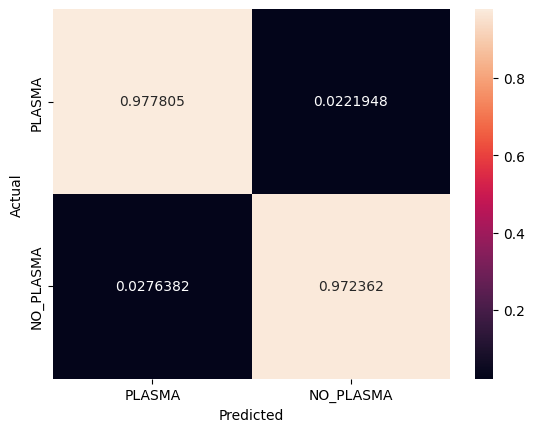

In [17]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns


def get_label(d):
  if d['label'] == 'PLASMA':
    return 0
  else:
    return 1



predictions = [get_label(d) for d in predictions]


print("acc:",accuracy_score(dataset['test']['label'], predictions))
print("f1:",f1_score(dataset['test']['label'], predictions, average = 'macro'))

# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['PLASMA','NO_PLASMA']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(dataset['test']['label'],predictions, normalize = 'true')
plot_cm(cm)


In [18]:
fined_model("The present invention relates to ionized gas with blood plasma.")

[{'label': 'NO_PLASMA', 'score': 0.6883924603462219}]

In [19]:
fined_model("The present invention relates to co2 gas.")

[{'label': 'NO_PLASMA', 'score': 0.8838509321212769}]

In [20]:
fined_model("The present invention relates tocancer tratment by using plasma.")

[{'label': 'PLASMA', 'score': 0.9696687459945679}]

In [21]:
fined_model("The present invention relates to an electromagnetic pulse protection method and an electromagnetic pulse protection system")

[{'label': 'NO_PLASMA', 'score': 0.9706006050109863}]

In [22]:
fined_model("The present invention relates to surface claening by microwave plasma")

[{'label': 'PLASMA', 'score': 0.9919465184211731}]

In [23]:
fined_model("The present disclosure generally relates to a surface cleaning apparatus")

[{'label': 'NO_PLASMA', 'score': 0.6860980987548828}]

In [24]:
!pip install pandas

In [25]:
import pandas as pd
df = pd.read_csv("plasma_test_data_annotated_.csv", encoding="utf-8")

predictions_df = fined_model(df['text'].tolist())
#predictions_df[:5]


In [26]:
predictions_df[:50]

[{'label': 'PLASMA', 'score': 0.9930866360664368},
 {'label': 'PLASMA', 'score': 0.9931094646453857},
 {'label': 'PLASMA', 'score': 0.9931636452674866},
 {'label': 'PLASMA', 'score': 0.9926748871803284},
 {'label': 'PLASMA', 'score': 0.9923906922340393},
 {'label': 'PLASMA', 'score': 0.9933297038078308},
 {'label': 'PLASMA', 'score': 0.9935681223869324},
 {'label': 'PLASMA', 'score': 0.992144763469696},
 {'label': 'PLASMA', 'score': 0.9863515496253967},
 {'label': 'PLASMA', 'score': 0.9929208159446716},
 {'label': 'PLASMA', 'score': 0.9894144535064697},
 {'label': 'PLASMA', 'score': 0.9927794337272644},
 {'label': 'PLASMA', 'score': 0.9932073950767517},
 {'label': 'PLASMA', 'score': 0.9924942255020142},
 {'label': 'PLASMA', 'score': 0.9922053217887878},
 {'label': 'NO_PLASMA', 'score': 0.7888873219490051},
 {'label': 'PLASMA', 'score': 0.9931657910346985},
 {'label': 'PLASMA', 'score': 0.9870102405548096},
 {'label': 'PLASMA', 'score': 0.9921820759773254},
 {'label': 'PLASMA', 'score':

acc: 0.9567567567567568
f1: 0.9558156197754956


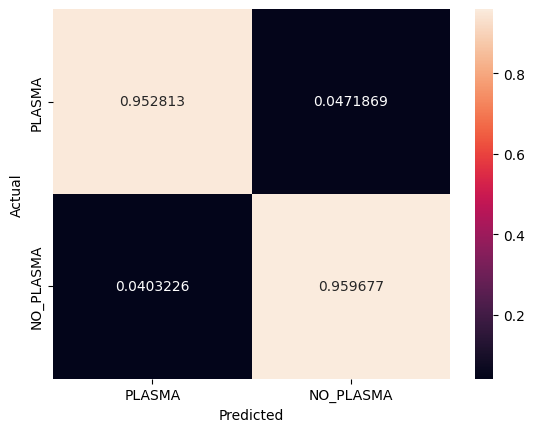

In [27]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns


def get_label(d):
  if d['label'] == 'PLASMA':
    return 0
  else:
    return 1



predictions = [get_label(d) for d in predictions_df]


print("acc:",accuracy_score(df['label'].tolist(), predictions))
print("f1:",f1_score(df['label'].tolist(), predictions, average = 'macro'))

# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['PLASMA','NO_PLASMA']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(df['label'].tolist(),predictions, normalize = 'true')
plot_cm(cm)


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import roc_curve,confusion_matrix,auc


In [37]:

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history):
# Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color='red', label='Train Loss')
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color='green', label='Val Loss',
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()


def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

def plot_cm(y_true, y_pred, title):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix

    Draws a Confusion Matrix for better understanding of how the model is working

    return None

    '''

    figsize=(10,10)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


## Calculate AUC (Area Under the Curve) 

In [44]:
y_predict_prob = []
for element in predictions_df:
  y_predict_prob.append(element['score'])


In [ ]:

y_valid = df['label'].tolist()
y_predict_prob = predictions
fpr, tpr, _ = roc_curve(y_valid,y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)